<a href="https://colab.research.google.com/github/silviolima07/animaeduca/blob/main/Anima_Enem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
#!pip install shap -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from IPython.core.pylabtools import figsize
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import shap

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline

In [4]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Seu dataframe tem " + str(df.shape[1]) + " colunas.\n"      
            "Há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que possuem valores ausentes.")
        
        return mis_val_table_ren_columns

In [5]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [6]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [7]:
def fit_and_evaluate(model):
    
    model.fit(X, y)
    
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [8]:
def sum_and_plot_importances(variables, importances):
    sum_importances = pd.DataFrame()
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        sum_importances = sum_importances.append(this_variable, ignore_index = True)
    plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
    return sum_importances 

In [9]:
df_dados = pd.read_csv('/content/drive/MyDrive/DATASETS/dado_mg.csv', sep=';')

In [10]:
df_dados

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001237802,2019,3118601,Contagem,31,MG,22.0,F,1,1,...,B,A,A,B,A,A,C,B,B,B
1,190001237803,2019,3170206,Uberlândia,31,MG,30.0,F,1,2,...,A,A,A,B,A,A,B,A,A,A
2,190001237804,2019,3124104,Esmeraldas,31,MG,27.0,M,1,3,...,A,A,A,B,A,B,C,A,A,A
3,190001237805,2019,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,...,B,A,B,C,B,A,E,A,B,B
4,190001237806,2019,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,...,B,A,A,B,B,A,C,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534622,190005766803,2019,3171204,Vespasiano,31,MG,23.0,M,1,2,...,B,A,A,C,A,B,D,A,B,B
534623,190005766804,2019,3170206,Uberlândia,31,MG,28.0,F,2,1,...,A,A,B,B,B,B,C,B,B,B
534624,190005766805,2019,3162500,São João del Rei,31,MG,20.0,M,1,4,...,B,A,B,C,B,B,C,B,B,B
534625,190005766806,2019,3158201,Santa Maria do Suaçuí,31,MG,18.0,F,1,3,...,A,A,A,B,A,A,B,A,A,A


In [233]:
#df_itens = pd.read_csv('/content/drive/MyDrive/DATASETS/ITENS_PROVA_2019.csv', sep=',')

In [234]:
#df_itens

## Identificar colunas com valores únicos.
## Colunas que apresentam os mesmos valores não auxiliam na criação de um modelo de machine.

In [11]:
colunas = df_dados.columns

In [12]:
colunas

Index(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       ...
       'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
       'Q025'],
      dtype='object', length=136)

In [13]:
cols = []
print("Coluna e quantidade de itens diferentes\n")
for col in colunas:
    teste = list(df_dados[col].value_counts())
    size = len(teste)
    print(col, ':',size)
    if size == 1:
      cols.append(col)
print("\nTotal de colunas com valores unicos:", len(cols))       

Coluna e quantidade de itens diferentes

NU_INSCRICAO : 534627
NU_ANO : 1
CO_MUNICIPIO_RESIDENCIA : 1490
NO_MUNICIPIO_RESIDENCIA : 1483
CO_UF_RESIDENCIA : 26
SG_UF_RESIDENCIA : 26
NU_IDADE : 73
TP_SEXO : 2
TP_ESTADO_CIVIL : 5
TP_COR_RACA : 6
TP_NACIONALIDADE : 5
CO_MUNICIPIO_NASCIMENTO : 3166
NO_MUNICIPIO_NASCIMENTO : 3083
CO_UF_NASCIMENTO : 27
SG_UF_NASCIMENTO : 27
TP_ST_CONCLUSAO : 4
TP_ANO_CONCLUIU : 14
TP_ESCOLA : 3
TP_ENSINO : 2
IN_TREINEIRO : 2
CO_ESCOLA : 3510
CO_MUNICIPIO_ESC : 996
NO_MUNICIPIO_ESC : 994
CO_UF_ESC : 22
SG_UF_ESC : 22
TP_DEPENDENCIA_ADM_ESC : 4
TP_LOCALIZACAO_ESC : 2
TP_SIT_FUNC_ESC : 4
IN_BAIXA_VISAO : 2
IN_CEGUEIRA : 2
IN_SURDEZ : 2
IN_DEFICIENCIA_AUDITIVA : 2
IN_SURDO_CEGUEIRA : 2
IN_DEFICIENCIA_FISICA : 2
IN_DEFICIENCIA_MENTAL : 2
IN_DEFICIT_ATENCAO : 2
IN_DISLEXIA : 2
IN_DISCALCULIA : 2
IN_AUTISMO : 2
IN_VISAO_MONOCULAR : 2
IN_OUTRA_DEF : 2
IN_GESTANTE : 2
IN_LACTANTE : 2
IN_IDOSO : 2
IN_ESTUDA_CLASSE_HOSPITALAR : 1
IN_SEM_RECURSO : 2
IN_BRAILLE : 2
IN_AMPL

In [14]:
df_dados[cols]

,NU_ANO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_GUIA_INTERPRETE,IN_PROVA_DEITADO,IN_MARCA_PASSO,CO_UF_PROVA,SG_UF_PROVA
0,2019,0,0,0,0,31,MG
1,2019,0,0,0,0,31,MG
2,2019,0,0,0,0,31,MG
3,2019,0,0,0,0,31,MG
4,2019,0,0,0,0,31,MG
...,...,...,...,...,...,...,...
534622,2019,0,0,0,0,31,MG
534623,2019,0,0,0,0,31,MG
534624,2019,0,0,0,0,31,MG
534625,2019,0,0,0,0,31,MG


## Essas colunas são removidas do dataset

In [15]:
df_dados2 = df_dados.drop(columns = list(cols))
df_dados2.shape

(534627, 129)

## Identificar colunas com dados ausentes e percentual em relacao ao total de linhas do dataset.
## Colunas com % Total Values acima de 50% serão removidas.

In [16]:
missing_values_table(df_dados2)

Seu dataframe tem 129 colunas.
Há 37 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
TP_LOCALIZACAO_ESC,427013,79.9
CO_ESCOLA,427013,79.9
CO_MUNICIPIO_ESC,427013,79.9
NO_MUNICIPIO_ESC,427013,79.9
CO_UF_ESC,427013,79.9
SG_UF_ESC,427013,79.9
TP_DEPENDENCIA_ADM_ESC,427013,79.9
TP_SIT_FUNC_ESC,427013,79.9
TP_ENSINO,246259,46.1
CO_PROVA_CN,143772,26.9


In [17]:
# Obtenha as colunas com > 50% de valores missing
missing_df = missing_values_table(df_dados2);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('Vamos remover %d colunas.' % len(missing_columns))

Seu dataframe tem 129 colunas.
Há 37 colunas que possuem valores ausentes.
Vamos remover 8 colunas.


In [18]:
df_dados3 = df_dados2.drop(columns = list(missing_columns))
df_dados3.shape

(534627, 121)

In [19]:
df_dados3

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001237802,3118601,Contagem,31,MG,22.0,F,1,1,1,...,B,A,A,B,A,A,C,B,B,B
1,190001237803,3170206,Uberlândia,31,MG,30.0,F,1,2,1,...,A,A,A,B,A,A,B,A,A,A
2,190001237804,3124104,Esmeraldas,31,MG,27.0,M,1,3,2,...,A,A,A,B,A,B,C,A,A,A
3,190001237805,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,1,...,B,A,B,C,B,A,E,A,B,B
4,190001237806,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,1,...,B,A,A,B,B,A,C,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534622,190005766803,3171204,Vespasiano,31,MG,23.0,M,1,2,1,...,B,A,A,C,A,B,D,A,B,B
534623,190005766804,3170206,Uberlândia,31,MG,28.0,F,2,1,1,...,A,A,B,B,B,B,C,B,B,B
534624,190005766805,3162500,São João del Rei,31,MG,20.0,M,1,4,1,...,B,A,B,C,B,B,C,B,B,B
534625,190005766806,3158201,Santa Maria do Suaçuí,31,MG,18.0,F,1,3,1,...,A,A,A,B,A,A,B,A,A,A


## Identificar a quantidade total de notas ausentes dos aluno inscrito no exame

In [20]:
notas = ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_LC']

In [21]:
for i in notas:
  print(i,'missing:',df_dados3[i].isnull().sum())

NU_NOTA_CH missing: 123452
NU_NOTA_CN missing: 143772
NU_NOTA_MT missing: 143772
NU_NOTA_REDACAO missing: 123452
NU_NOTA_LC missing: 123452


In [22]:
df_dados3[notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
0,575.5,513.6,677.0,860.0,570.7
1,NaN,NaN,NaN,NaN,NaN
2,494.1,394.3,397.5,600.0,479.5
3,592.0,560.0,695.1,540.0,591.1
4,554.6,504.2,462.4,580.0,519.7
...,...,...,...,...,...
534622,601.2,562.0,712.4,840.0,594.8
534623,NaN,NaN,NaN,NaN,NaN
534624,476.4,524.0,545.5,700.0,552.9
534625,NaN,NaN,NaN,NaN,NaN


## Identificar a quantidade de notas ausentes por aluno / por linha no dataset

In [23]:
temp_CH= np.where(df_dados3.NU_NOTA_CH.isnull(),1,0)
#
temp_CN= np.where(df_dados3.NU_NOTA_CN.isnull(),1,0)
#
temp_MT= np.where(df_dados3.NU_NOTA_MT.isnull(),1,0)
#
temp_REDACAO= np.where(df_dados3.NU_NOTA_REDACAO.isnull(),1,0)
#
temp_LC= np.where(df_dados3.NU_NOTA_LC.isnull(),1,0)

In [24]:
temp_CH

array([0, 1, 0, ..., 0, 1, 0])

## Quantidade de notas ausentes por linha / por aluno no dataset

In [25]:
temp_sum_nan = temp_CH+temp_CN+temp_MT+temp_REDACAO+temp_LC

In [26]:
temp_sum_nan

array([0, 5, 0, ..., 0, 5, 0])

In [27]:
df_dados3['total_nan'] = temp_sum_nan

In [28]:
df_dados3.total_nan.value_counts()

0    390085
5    122682
2     21090
3       770
Name: total_nan, dtype: int64

## Existem 122682 inscritos que possuem 0 zero notas computadas

In [29]:
df_dados3.loc[df_dados3.total_nan == 5][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
1,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
534615,NaN,NaN,NaN,NaN,NaN
534616,NaN,NaN,NaN,NaN,NaN
534617,NaN,NaN,NaN,NaN,NaN
534623,NaN,NaN,NaN,NaN,NaN


## Existem 770 inscritos que possuem 2 notas computadas

In [30]:
df_dados3.loc[df_dados3.total_nan == 3][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
110,NaN,371.8,502.7,NaN,NaN
1086,NaN,514.0,485.9,NaN,NaN
1857,NaN,527.3,701.4,NaN,NaN
3571,NaN,468.9,569.3,NaN,NaN
3624,NaN,445.5,526.9,NaN,NaN
...,...,...,...,...,...
531144,NaN,385.6,397.4,NaN,NaN
531263,NaN,527.5,631.3,NaN,NaN
532116,NaN,429.1,489.3,NaN,NaN
532480,NaN,415.3,482.2,NaN,NaN


## Existem 21090 inscritos que possuem 3 computadas


In [31]:
df_dados3.loc[df_dados3.total_nan == 2][notas]

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
9,514.3,NaN,NaN,500.0,554.4
19,564.9,NaN,NaN,540.0,527.8
66,651.3,NaN,NaN,620.0,628.7
84,587.1,NaN,NaN,840.0,610.1
147,598.6,NaN,NaN,940.0,583.0
...,...,...,...,...,...
534450,509.5,NaN,NaN,400.0,538.5
534509,559.9,NaN,NaN,440.0,561.7
534531,496.9,NaN,NaN,400.0,515.8
534544,471.3,NaN,NaN,0.0,352.4


In [32]:
#Total de linhas do dataset
total_linhas = df_dados3.shape[0]

In [33]:
# Percentual de linhas com 5 notas ausentes
missing_5 = (df_dados3.loc[df_dados3.total_nan == 5]).shape[0]
#
percent_5 = round(missing_5/float(total_linhas)*100,2)
#
print("Total linhas com 5 notas ausentes:", missing_5,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_5)+'%')

Total linhas com 5 notas ausentes: 122682 
Total de linhas no dataset: 534627 
Percentual: 22.95%


In [34]:
# Percentual de linhas com 3 notas ausentes
missing_3 = (df_dados3.loc[df_dados3.total_nan == 3]).shape[0]
#
percent_3 = round(missing_3/float(total_linhas)*100,2)
#
print("Total linhas com 3 notas ausentes:", missing_3,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_3)+'%')

Total linhas com 3 notas ausentes: 770 
Total de linhas no dataset: 534627 
Percentual: 0.14%


In [35]:
# Percentual de linhas com 2 notas ausentes
missing_2 = (df_dados3.loc[df_dados3.total_nan == 2]).shape[0]
#
percent_2 = round(missing_2/float(total_linhas)*100,2)
#
print("Total linhas com 2 notas ausentes:", missing_2,
      '\nTotal de linhas no dataset:', total_linhas,
      '\nPercentual:', str(percent_2)+'%')

Total linhas com 2 notas ausentes: 21090 
Total de linhas no dataset: 534627 
Percentual: 3.94%


In [36]:
data = {'% Missing_5':[percent_5],
        '% Missing_3':[percent_3],
        '% Missing_2':[percent_2]}

df_notas_missing = pd.DataFrame(data)        

In [37]:
df_notas_missing

,% Missing_5,% Missing_3,% Missing_2
0,22.95,0.14,3.94


## Alunos inscritos com 5 notas missing serão removidos.

In [38]:
df_dados4 = df_dados3.loc[df_dados3.total_nan != 5]
df_dados4

,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,total_nan
0,190001237802,3118601,Contagem,31,MG,22.0,F,1,1,1,...,A,A,B,A,A,C,B,B,B,0
2,190001237804,3124104,Esmeraldas,31,MG,27.0,M,1,3,2,...,A,A,B,A,B,C,A,A,A,0
3,190001237805,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,1,...,A,B,C,B,A,E,A,B,B,0
4,190001237806,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,1,...,A,A,B,B,A,C,A,B,B,0
7,190001237809,3157005,Salinas,31,MG,20.0,M,1,3,1,...,A,A,B,A,A,E,A,B,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,190005766801,3118601,Contagem,31,MG,17.0,M,1,2,1,...,A,A,B,B,A,D,A,B,A,0
534621,190005766802,3170206,Uberlândia,31,MG,19.0,F,1,3,1,...,A,A,B,B,A,B,A,A,B,0
534622,190005766803,3171204,Vespasiano,31,MG,23.0,M,1,2,1,...,A,A,C,A,B,D,A,B,B,0
534624,190005766805,3162500,São João del Rei,31,MG,20.0,M,1,4,1,...,A,B,C,B,B,C,B,B,B,0


In [39]:
df_dados4.total_nan.value_counts()

0    390085
2     21090
3       770
Name: total_nan, dtype: int64

## Estatistica descritiva das colunas de notas no dataset

In [40]:
df_dados4[notas].describe()

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
count,411175.000000,390855.000000,390855.000000,411175.000000,411175.000000
mean,521.041378,492.484947,546.987343,597.213936,531.352800
std,83.231032,78.014744,115.132503,192.931916,61.295952
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,462.600000,430.600000,451.900000,500.000000,497.600000
50%,526.700000,489.500000,531.600000,600.000000,536.700000
75%,580.500000,551.200000,630.100000,720.000000,573.000000
max,835.100000,842.800000,985.500000,1000.000000,770.500000


## Identificar valores muito acima e muito abaixo, considerados outliers.
## Esses valores ultrapassam os limites definidos a partir do IQR calculado.

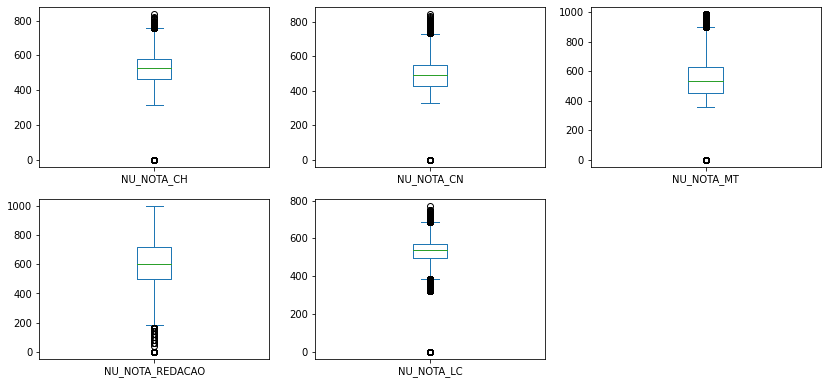

In [41]:
df_dados4[notas].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

## Aplicar a função que irá remover valores acima e abaixo determinados limites definidos pelo IQR
- IQR - Interquartile range

In [42]:
df_CH = remove_outlier(df_dados4, 'NU_NOTA_CH')
#
df_CN = remove_outlier(df_CH, 'NU_NOTA_CN')
#
df_MT = remove_outlier(df_CN, 'NU_NOTA_MT')
#
df_REDACAO = remove_outlier(df_MT, 'NU_NOTA_REDACAO')
#
df_LC = remove_outlier(df_REDACAO, 'NU_NOTA_LC')


## Ao remover outliers da coluna NU_NOTA_CH, foram removidas linhas com 3 notas ausentes.

In [43]:
df_CH.total_nan.value_counts()

0    389744
2     20735
Name: total_nan, dtype: int64

In [44]:
df_CN.shape

(389358, 122)

## Ao remover outliers da coluna NU_NOTA_CN, foram removidas as linhas com 2 notas ausentes. Agora o dataset possue as 5 notas de cada aluno inscrito.

In [45]:
df_CN.total_nan.value_counts()

0    389358
Name: total_nan, dtype: int64

In [46]:
df_MT.shape

(388859, 122)

In [47]:
df_REDACAO.shape

(380579, 122)

In [48]:
df_LC.shape

(372912, 122)

## A função que remove outliers removeu as linhas cujas notas estavam acima ou abaixo do IQR. Restauram 372912 linhas onde todas as notas estão presentes.

In [49]:
df_dados5= df_LC

In [50]:
df_dados5.shape

(372912, 122)

In [51]:
df_dados5.total_nan.value_counts()

0    372912
Name: total_nan, dtype: int64

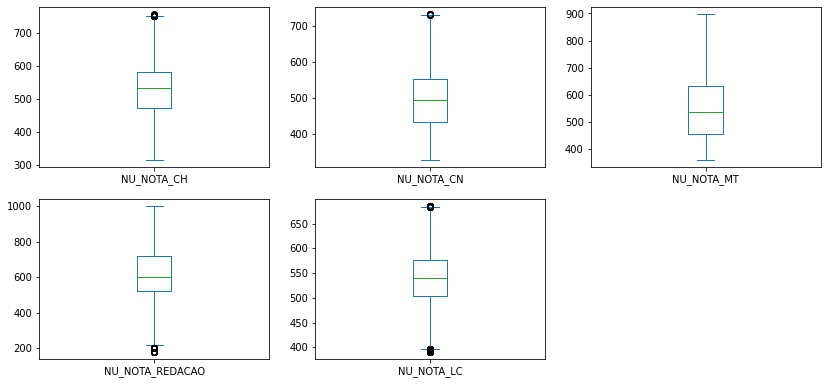

In [52]:
df_dados5[notas].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

In [53]:
df_dados5[notas].describe()

,NU_NOTA_CH,NU_NOTA_CN,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_LC
count,372912.000000,372912.000000,372912.000000,372912.000000,372912.000000
mean,527.262197,494.737302,549.879768,621.368151,537.723904
std,78.572104,76.519882,113.366251,164.055295,53.067262
min,315.900000,327.900000,359.000000,180.000000,391.200000
25%,471.900000,433.800000,455.700000,520.000000,503.900000
50%,532.900000,493.000000,536.500000,600.000000,540.400000
75%,583.900000,552.800000,633.000000,720.000000,575.400000
max,757.300000,731.800000,896.500000,1000.000000,684.800000


## Dataset df_dados6 tera as colunas de notas com os pesos atributos.
## Serão criadas novas colunas para receber notas com os respectivos pesos aplicados.

In [54]:
df_dados6 = df_dados5
df_dados6.shape

(372912, 122)

## Notas com os respectivos pesos atribuidos
- NU_NOTA_CN peso 1
- NU_NOTA_CH peso 3
- NU_NOTA_MT_ peso 1
- NU_NOTA_REDACAO peso 3
- NU_NOTA_LC peso 2

In [55]:
df_dados6['NU_NOTA_CN_1'] = df_dados6.NU_NOTA_CH
#
df_dados6['NU_NOTA_CH_3'] = 3*df_dados6.NU_NOTA_CH
#
df_dados6['NU_NOTA_MT_1'] = df_dados6.NU_NOTA_MT
#
df_dados6['NU_NOTA_REDACAO_3'] = 3*df_dados6.NU_NOTA_REDACAO
#
df_dados6['NU_NOTA_LC_2'] = 2*df_dados6.NU_NOTA_LC

In [56]:
notas_peso = ['NU_INSCRICAO','NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2']

In [57]:
df_dados6[notas_peso]

,NU_INSCRICAO,NU_NOTA_CN_1,NU_NOTA_CH_3,NU_NOTA_MT_1,NU_NOTA_REDACAO_3,NU_NOTA_LC_2
0,190001237802,575.5,1726.5,677.0,2580.0,1141.4
2,190001237804,494.1,1482.3,397.5,1800.0,959.0
3,190001237805,592.0,1776.0,695.1,1620.0,1182.2
4,190001237806,554.6,1663.8,462.4,1740.0,1039.4
7,190001237809,555.5,1666.5,729.8,2520.0,1114.0
...,...,...,...,...,...,...
534620,190005766801,528.2,1584.6,491.7,1560.0,1073.8
534621,190005766802,455.1,1365.3,463.1,1380.0,1085.2
534622,190005766803,601.2,1803.6,712.4,2520.0,1189.6
534624,190005766805,476.4,1429.2,545.5,2100.0,1105.8


## Nova coluna com a Media Ponderada das notas de cada aluno
#Media ponderada seria a soma das notas notas com os pesos aplicados dividido pela soma dos pesos (10).

In [58]:
df_dados6['med_pond']= (df_dados6['NU_NOTA_CN_1'] +  df_dados6['NU_NOTA_CH_3'] + df_dados6['NU_NOTA_MT_1'] + df_dados6['NU_NOTA_REDACAO_3'] + df_dados6['NU_NOTA_LC_2'])/10


In [59]:
df_dados6[['NU_INSCRICAO','NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2', 'med_pond']]

,NU_INSCRICAO,NU_NOTA_CN_1,NU_NOTA_CH_3,NU_NOTA_MT_1,NU_NOTA_REDACAO_3,NU_NOTA_LC_2,med_pond
0,190001237802,575.5,1726.5,677.0,2580.0,1141.4,670.04
2,190001237804,494.1,1482.3,397.5,1800.0,959.0,513.29
3,190001237805,592.0,1776.0,695.1,1620.0,1182.2,586.53
4,190001237806,554.6,1663.8,462.4,1740.0,1039.4,546.02
7,190001237809,555.5,1666.5,729.8,2520.0,1114.0,658.58
...,...,...,...,...,...,...,...
534620,190005766801,528.2,1584.6,491.7,1560.0,1073.8,523.83
534621,190005766802,455.1,1365.3,463.1,1380.0,1085.2,474.87
534622,190005766803,601.2,1803.6,712.4,2520.0,1189.6,682.68
534624,190005766805,476.4,1429.2,545.5,2100.0,1105.8,565.69


## Remover colunas criadas e não necessarias no modelo.
## Colunas: 
- 'NU_INSCRICAO'
- 'NU_NOTA_CN_1', 'NU_NOTA_CH_3', 'NU_NOTA_MT_1', 'NU_NOTA_REDACAO_3', 'NU_NOTA_LC_2'
-  total_nan

In [60]:
df_dados7 = df_dados6.drop(columns = list(notas_peso))
df_dados7 = df_dados7.drop(columns = ['total_nan'])
df_dados7.shape

(372912, 121)

In [61]:
df_dados7.columns

Index(['CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'CO_MUNICIPIO_NASCIMENTO',
       ...
       'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'med_pond'],
      dtype='object', length=121)

In [62]:
df_dados7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372912 entries, 0 to 534626
Columns: 121 entries, CO_MUNICIPIO_RESIDENCIA to med_pond
dtypes: float64(20), int64(63), object(38)
memory usage: 347.1+ MB


In [63]:
df_object = df_dados7.select_dtypes('object')

In [64]:
df_object

,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,NO_MUNICIPIO_NASCIMENTO,SG_UF_NASCIMENTO,NO_MUNICIPIO_PROVA,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,Contagem,MG,F,Contagem,MG,Contagem,EEBEDEEEEEBDCEEBEEEEABEEBEEBAEDEECECCDBCECEAE,EEDCCEDDBCBEABAAABADCEDABDBBCBDCCCCDAEDEDBDCB,ABBBE99999ABBCACCCAEEEDCCDADCCAEDEDDEEDBBDECBD...,CDEEEEEAEECBABABCDCACEEEEEEDEEACEAEDEBEEECEDE,...,B,A,A,B,A,A,C,B,B,B
2,Esmeraldas,MG,M,NaN,NaN,Esmeraldas,BDCBDBDECCCBDBBDDCEBBCDDBBDEDDBBBBBCDCDDCBBAC,CECCCCACABBAAABAECEEDCDACCBABCCAACDECBDDBBDEB,BCBAD99999BBBBCCEBCBBEDDAADDACCBABBBBCECADECCA...,ECBEBDDCCDDDBBDBBBEDBBDAABCEDCBCBCCBCADCBCCAB,...,A,A,A,B,A,B,C,A,A,A
3,Conselheiro Lafaiete,MG,F,Conselheiro Lafaiete,MG,Conselheiro Lafaiete,ABCABEDBCCCCAECACEBDCACDBCCBABAEDAEDBBDDDAAAE,ACBCEEACABAEACBDBCCABEABAEBADCACADCDCEDBBBEAB,BBBAD99999BBCBCDBDEBBAADCDDDDECEDBAEBCCACDCBCA...,DCEBAECCADCACEEECEACADAAEEBDAEBDAAADCEDDBEDEC,...,B,A,B,C,B,A,E,A,B,B
4,São Joaquim de Bicas,MG,F,Contagem,MG,São Joaquim de Bicas,BAEABEDBCDBAECDACBAEDBDEDBBABADEEECCCAACDDAEE,ABCAADBDCECECCBAECBBBABCAEBEDBBCBBAACEBAECBBB,CAEED99999ACABCEDEDECDDCDCDAADDDCBBAEDBEECBDED...,BAEEADEBDDCCDCCBDDCBCCEDADADABADAAACDECCAEEDB,...,B,A,A,B,B,A,C,A,B,B
7,Salinas,MG,M,Salinas,MG,Salinas,DBEAADBCEBDBEADACDBDACAAEDABAACBCCDEECACDAAAB,BEBBAAAEEBACACAEEDCECECBEADAEEBBAAEDADBEEDBDB,BADAE99999BCEABEDCACEEAECBEEDCDCACADEBDAEDDEAC...,CABEABAADDABAECBEDBDEECCDDCAACADECEDCDABCEEAD,...,A,A,A,B,A,A,E,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,Contagem,MG,M,Contagem,MG,Belo Horizonte,CEBCABCEEABEBDDCADAEBBCEEEAEDEEADDECCABDCAEBB,ABCAACBDBEAEBCABADAEBEBAAADBEAEEBBEBCEBAACEDB,BCCCD99999CEAEEEABAECEDCEECBECBBEDEAADDBECBCEA...,DBDAADEBBEACDEBCBECAADCAEDABEEABCDEEAACBEDBAC,...,B,A,A,B,B,A,D,A,B,A
534621,Uberlândia,MG,F,Uberlândia,MG,Uberlândia,CBEDEDABEEBCEDDEDBCEEACEDBAADDBCCDABCDAECCCAD,AECEABDDCBABCCDEABCADECCCDBAADDADDEECEABDDCAB,EDBAB99999BDCADABCEBBAEDBEEABECEDBEBBDDECDCEAC...,AECACCABBECDDBCCCDAAADDACECBBACDCAAEDCCEBBACC,...,B,A,A,B,B,A,B,A,A,B
534622,Vespasiano,MG,M,Belo Horizonte,MG,Vespasiano,BDCCAECEEBDAEDDABEAEDECDDBCBBABACCAEACBBBCDDE,ECBCABAACBECACECEADECBCCEDBCCAEBAEDDADBDEACDB,BDABE99999BEBEACDDECDAAECAEDADDCBCCAEBAAADEBDC...,CACECEAADEBBADCBDDBACEABCEEAECBCAEDBCDABECADE,...,B,A,A,C,A,B,D,A,B,B
534624,São João del Rei,MG,M,São João del Rei,MG,São João del Rei,DADDBBCCEBAECBABACEEACCDBEABBEDDABDCAEEBCADDB,ACADCDBEEABCBDAECCBDDAEAACBEACDACACDEBDBAECCD,ADBBE99999CCEDBCCEAECDDBDAAAEDBAECCEBBDABECCAD...,ADDAEBBCEADBADDBAEDACCBEEBCBEACDAACBEBAEECDAB,...,B,A,B,C,B,B,C,B,B,B


## Identificar as variaveis tipo object com mais de 5 valores únicos

In [65]:
colunas_obj = df_object.columns

In [66]:
cols = []
print("Coluna e quantidade de itens diferentes\n")
for col in colunas_obj:
    teste = list(df_object[col].value_counts())
    size = len(teste)
    print(col, ':',size)
    if size > 5:
      cols.append(col)
print("\nTotal de colunas com mais de 5 valores unicos:", len(cols))  

Coluna e quantidade de itens diferentes

NO_MUNICIPIO_RESIDENCIA : 1292
SG_UF_RESIDENCIA : 26
TP_SEXO : 2
NO_MUNICIPIO_NASCIMENTO : 2713
SG_UF_NASCIMENTO : 27
NO_MUNICIPIO_PROVA : 188
TX_RESPOSTAS_CN : 372806
TX_RESPOSTAS_CH : 372856
TX_RESPOSTAS_LC : 372900
TX_RESPOSTAS_MT : 372837
TX_GABARITO_CN : 6
TX_GABARITO_CH : 4
TX_GABARITO_LC : 4
TX_GABARITO_MT : 7
Q001 : 8
Q002 : 8
Q003 : 6
Q004 : 6
Q006 : 17
Q007 : 4
Q008 : 5
Q009 : 5
Q010 : 5
Q011 : 5
Q012 : 5
Q013 : 5
Q014 : 5
Q015 : 5
Q016 : 5
Q017 : 5
Q018 : 2
Q019 : 5
Q020 : 2
Q021 : 2
Q022 : 5
Q023 : 2
Q024 : 5
Q025 : 2

Total de colunas com mais de 5 valores unicos: 16


## Variaveis com muitos valores únicos não ser uteis oara o treinamento do modelo.
## Pois o objetivo é encontrar padrões de comportamentos dos dados.

In [67]:
df_object.drop(columns = list(cols), inplace=True)
df_object.shape

(372912, 22)

In [68]:
df_object

,TP_SEXO,TX_GABARITO_CH,TX_GABARITO_LC,Q007,Q008,Q009,Q010,Q011,Q012,Q013,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,F,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,A,C,D,B,A,B,B,...,B,A,A,B,A,A,C,B,B,B
2,M,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,A,B,C,A,A,B,A,...,A,A,A,B,A,B,C,A,A,A
3,F,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,A,B,D,B,B,B,A,...,B,A,B,C,B,A,E,A,B,B
4,F,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,A,B,C,B,A,B,A,...,B,A,A,B,B,A,C,A,B,B
7,M,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,A,B,D,A,A,B,A,...,A,A,A,B,A,A,E,A,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,M,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,A,B,C,A,A,B,B,...,B,A,A,B,B,A,D,A,B,A
534621,F,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,A,B,C,B,A,B,A,...,B,A,A,B,B,A,B,A,A,B
534622,M,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,A,D,D,C,A,B,B,...,B,A,A,C,A,B,D,A,B,B
534624,M,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,A,C,C,B,B,B,A,...,B,A,B,C,B,B,C,B,B,B


## Foi criado um dataset onde as colunas foram convertidas em valores numericos.
## Dessa forma pode analisar a correlacao da variavel e a coluna target, med_pond.

In [69]:
df_object_dummies = pd.get_dummies(data=df_object)

In [70]:
df_object_dummies['med_pond'] = df_dados7.med_pond

## Nenhuma coluna apresentou um alto valor de correlacao.
## Por isso serao nao removidas do dataset.

In [71]:
df_object_dummies.corrwith(df_object_dummies['med_pond'])

TP_SEXO_F                                                      -0.038991
TP_SEXO_M                                                       0.038991
TX_GABARITO_CH_ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB   -0.002000
TX_GABARITO_CH_BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB   -0.003633
TX_GABARITO_CH_CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC   -0.001214
                                                                  ...   
Q024_D                                                          0.152911
Q024_E                                                          0.112100
Q025_A                                                         -0.206463
Q025_B                                                          0.206463
med_pond                                                        1.000000
Length: 90, dtype: float64

In [72]:
df_dados7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372912 entries, 0 to 534626
Columns: 121 entries, CO_MUNICIPIO_RESIDENCIA to med_pond
dtypes: float64(20), int64(63), object(38)
memory usage: 347.1+ MB


## O dataset tera apenas as variaveis numericas.

In [73]:
df_dados8 = df_dados7.select_dtypes('number')

In [74]:
df_dados8.shape

(372912, 83)

## Identificar no dataset colunas com dados ausentes

In [75]:
missing_values_table(df_dados8)

Seu dataframe tem 83 colunas.
Há 4 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
TP_ENSINO,169428,45.4
CO_MUNICIPIO_NASCIMENTO,10870,2.9
CO_UF_NASCIMENTO,10870,2.9
NU_IDADE,6,0.0


## A variavel TP_ENSINO apresenta como mais frequente o valor 1.0
## A estrategia adotada foi immputar pelo valor mais frequente nessa variavel.
## A mesma estrategia foi aplicada nas outras 3 variaveis.
## Como percentual de dados ausentes nessas 3 variaveis é baixo, isso não impactará no modelo gerado.

In [76]:
df_dados8.TP_ENSINO.value_counts()

1.0    202435
2.0      1049
Name: TP_ENSINO, dtype: int64

In [77]:
df_dados8.CO_MUNICIPIO_NASCIMENTO.value_counts()

3106200.0    60512
3143302.0    11058
3170206.0    10993
3136702.0     9221
3118601.0     8860
             ...  
2105104.0        1
1300805.0        1
3503000.0        1
4125100.0        1
2201200.0        1
Name: CO_MUNICIPIO_NASCIMENTO, Length: 2769, dtype: int64

In [78]:
df_dados8.CO_UF_NASCIMENTO.value_counts()

31.0    338707
35.0      9278
33.0      3167
29.0      2116
52.0      1455
53.0      1171
32.0      1124
15.0       658
21.0       579
41.0       485
27.0       458
26.0       401
23.0       379
51.0       318
43.0       218
22.0       201
50.0       186
17.0       184
11.0       179
13.0       163
25.0       154
24.0       138
42.0       116
28.0        91
12.0        53
16.0        39
14.0        24
Name: CO_UF_NASCIMENTO, dtype: int64

In [79]:
df_dados8.NU_IDADE.value_counts()

18.0    75430
17.0    70122
19.0    45781
20.0    29835
16.0    27969
        ...  
11.0        1
83.0        1
76.0        1
10.0        1
82.0        1
Name: NU_IDADE, Length: 71, dtype: int64

## Valores ausentes serão preenchidos pelo valor mais frequente nessas colunas.

In [80]:
df_dados8.fillna(df_dados8.mode().iloc[0], inplace=True)

## Identificar valores outliers na coluna NU_IDADE

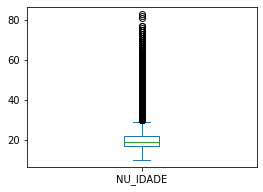

In [81]:
df_dados8['NU_IDADE'].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

In [82]:
df_dados9 = remove_outlier(df_dados8,'NU_IDADE')

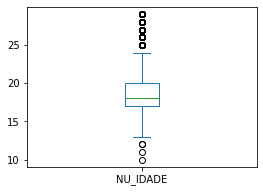

In [83]:
df_dados9['NU_IDADE'].plot(kind= 'box' , subplots=True, layout=(3,3),figsize=(14,10));

## Criar 2 grupos representando as idades entre 17 e 21, que representam mais de 70% dos dados de idades.
- Grupo1 : 17 a 21
- Grupo2 : as demais idades

In [84]:
df_dados9.NU_IDADE.value_counts(normalize=True)

18.0    0.222885
17.0    0.207184
19.0    0.135266
20.0    0.088151
16.0    0.082638
21.0    0.058759
22.0    0.045197
23.0    0.034563
24.0    0.027354
25.0    0.021696
15.0    0.020656
26.0    0.017766
27.0    0.014590
28.0    0.012247
29.0    0.010350
14.0    0.000650
13.0    0.000035
12.0    0.000006
11.0    0.000003
10.0    0.000003
Name: NU_IDADE, dtype: float64

In [85]:
temp = np.where((df_dados9.NU_IDADE >= 17) & (df_dados9.NU_IDADE <=21) , 1, 2 )
df_dados9['GRUPO'] = temp

## Identificar as variaveis com mais de 5 valores únicos.

In [86]:
colunas = df_dados9.columns.to_list()
colunas.remove('med_pond')

In [87]:
cols = []
print("Coluna e quantidade de itens diferentes\n")
for col in colunas:
    teste = list(df_dados9[col].value_counts())
    size = len(teste)
    print(col, ':',size)
    if (size > 5) or (size == 1):
      cols.append(col)
print("\nTotal de colunas com mais de 5 valores unicos:", len(cols)) 

Coluna e quantidade de itens diferentes

CO_MUNICIPIO_RESIDENCIA : 1276
CO_UF_RESIDENCIA : 26
NU_IDADE : 20
TP_ESTADO_CIVIL : 5
TP_COR_RACA : 6
TP_NACIONALIDADE : 5
CO_MUNICIPIO_NASCIMENTO : 2557
CO_UF_NASCIMENTO : 27
TP_ST_CONCLUSAO : 4
TP_ANO_CONCLUIU : 14
TP_ESCOLA : 3
TP_ENSINO : 2
IN_TREINEIRO : 2
IN_BAIXA_VISAO : 2
IN_CEGUEIRA : 2
IN_SURDEZ : 2
IN_DEFICIENCIA_AUDITIVA : 2
IN_SURDO_CEGUEIRA : 2
IN_DEFICIENCIA_FISICA : 2
IN_DEFICIENCIA_MENTAL : 2
IN_DEFICIT_ATENCAO : 2
IN_DISLEXIA : 2
IN_DISCALCULIA : 2
IN_AUTISMO : 2
IN_VISAO_MONOCULAR : 2
IN_OUTRA_DEF : 2
IN_GESTANTE : 2
IN_LACTANTE : 2
IN_IDOSO : 1
IN_SEM_RECURSO : 2
IN_BRAILLE : 2
IN_AMPLIADA_24 : 2
IN_AMPLIADA_18 : 2
IN_LEDOR : 2
IN_ACESSO : 2
IN_TRANSCRICAO : 2
IN_LIBRAS : 2
IN_TEMPO_ADICIONAL : 2
IN_LEITURA_LABIAL : 2
IN_MESA_CADEIRA_RODAS : 2
IN_MESA_CADEIRA_SEPARADA : 2
IN_APOIO_PERNA : 2
IN_COMPUTADOR : 2
IN_CADEIRA_ESPECIAL : 1
IN_CADEIRA_CANHOTO : 2
IN_CADEIRA_ACOLCHOADA : 2
IN_MOBILIARIO_OBESO : 2
IN_LAMINA_OVERLAY : 2

In [88]:
df_dados9 = df_dados9.drop(columns = list(cols))
df_dados9.shape

(338452, 53)

## A coluna NU_IDADE foi removida e a coluna GRUPO a substitui, representando as idades divididas em 2 grupos.
- Grupo 1: alunos entre 17 e 21 anos, grupo que representa mais de 70%
- Grupo 2: demais idades dos alunos

In [89]:
df_dados9[['med_pond',   'GRUPO']]

,med_pond,GRUPO
0,670.04,2
2,513.29,2
3,586.53,2
4,546.02,2
7,658.58,1
...,...,...
534620,523.83,1
534621,474.87,1
534622,682.68,2
534624,565.69,1


In [90]:
df_dados9.GRUPO.value_counts(normalize=True)

1    0.712246
2    0.287754
Name: GRUPO, dtype: float64

In [91]:
df_dados9

,TP_ESTADO_CIVIL,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,...,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,TP_LINGUA,med_pond,GRUPO
0,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,670.04,2
2,1,2,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,513.29,2
3,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,586.53,2
4,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,546.02,2
7,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,658.58,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,1,1,2,2,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,523.83,1
534621,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,474.87,1
534622,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,682.68,2
534624,1,1,1,1,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,565.69,1


## Identifcar a correlacao das variaveis com a variavel target, med_pond.

In [92]:
correlations_data = df_dados9.corr()['med_pond'].sort_values()

print(correlations_data.head(15), '\n')
print(correlations_data.tail(15))

TP_LINGUA               -0.201041
TP_NACIONALIDADE        -0.053317
GRUPO                   -0.047107
TP_ESTADO_CIVIL         -0.038197
TP_ENSINO               -0.017627
TP_ST_CONCLUSAO         -0.015797
IN_LEDOR                -0.014767
IN_DEFICIENCIA_MENTAL   -0.013261
IN_SURDEZ               -0.011800
IN_TRANSCRICAO          -0.011548
IN_DEFICIENCIA_FISICA   -0.011498
IN_ACESSO               -0.010262
IN_BAIXA_VISAO          -0.009230
IN_MESA_CADEIRA_RODAS   -0.007739
IN_LIBRAS               -0.007656
Name: med_pond, dtype: float64 

IN_SONDA                    0.002058
IN_MATERIAL_ESPECIFICO      0.002414
IN_MESA_CADEIRA_SEPARADA    0.002455
IN_TREINEIRO                0.002685
IN_CADEIRA_ACOLCHOADA       0.003093
IN_DISLEXIA                 0.006856
IN_NOME_SOCIAL              0.007671
IN_SALA_INDIVIDUAL          0.008937
IN_MEDICAMENTOS             0.009850
IN_MEDIDOR_GLICOSE          0.012935
IN_OUTRA_DEF                0.015041
IN_TEMPO_ADICIONAL          0.063311
IN_DEFICIT_AT

## Treino e Teste

In [93]:
features = df_dados9.drop(columns='med_pond')
targets = pd.DataFrame(df_dados9['med_pond'])

In [94]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(236916, 52)
(101536, 52)
(236916, 1)
(101536, 1)


## Baseline

In [95]:
baseline_guess = np.median(y)

print('O palpite da linha de base é uma pontuação de %0.2f' % baseline_guess)
print("Desempenho de linha de base no conjunto de testes: MAE = %0.4f" % mae(y_test, baseline_guess))

O palpite da linha de base é uma pontuação de 557.12
Desempenho de linha de base no conjunto de testes: MAE = 72.1457


## Padronização

In [96]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(X)

X = scaler.transform(X)
X_test = scaler.transform(X_test)

#
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

## Previsao

In [97]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Performance do Linear Regression nos dados de teste: MAE = %0.4f' % lr_mae)

Performance do Linear Regression nos dados de teste: MAE = 68.3412


In [98]:
#svm = SVR(C = 1000, gamma = 0.1)
#svm_mae = fit_and_evaluate(svm)

#print('Performance do Support Vector Machine Regression nos dados de teste: MAE = %0.4f' % svm_mae)

In [102]:
random_forest = RandomForestRegressor(n_estimators=  500, random_state=60)

random_forest_mae = fit_and_evaluate(random_forest)

print('Performance do Random Forest Regression nos dados de teste: MAE = %0.4f' % random_forest_mae)

Performance do Random Forest Regression nos dados de teste: MAE = 67.0411


In [103]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Performance doo Gradient Boosted Regression nos dados de teste: MAE = %0.4f' % gradient_boosted_mae)

Performance doo Gradient Boosted Regression nos dados de teste: MAE = 67.0445


In [104]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = %0.4f' % knn_mae)

Performance do K-Nearest Neighbors Regression nos dados de teste: MAE = 72.1293


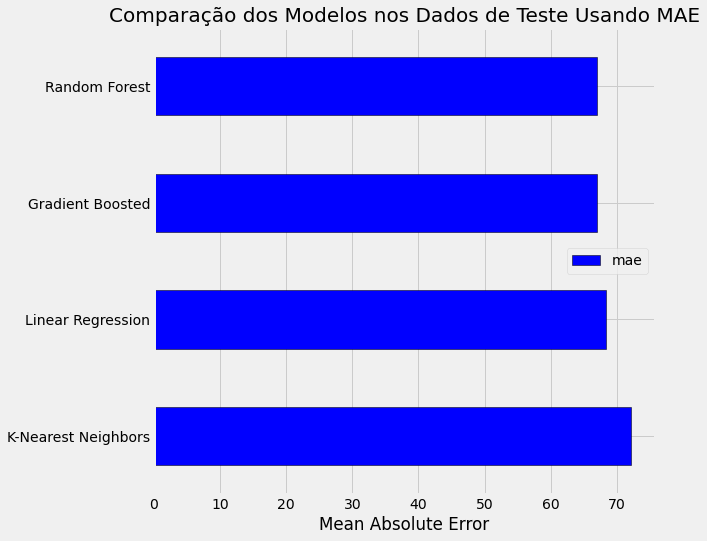

In [105]:
plt.style.use('fivethirtyeight')
figsize(8, 8)


# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae,random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Comparação dos Modelos nos Dados de Teste Usando MAE', size = 20);

## Feature Importance a partir do modelo random forest


Feature 0 : TP_ESTADO_CIVIL  Score: 0.021
Feature 1 : TP_NACIONALIDADE  Score: 0.042
Feature 2 : TP_ST_CONCLUSAO  Score: 0.03
Feature 3 : TP_ESCOLA  Score: 0.527
Feature 4 : TP_ENSINO  Score: 0.002
Feature 5 : IN_TREINEIRO  Score: 0.005
Feature 6 : IN_BAIXA_VISAO  Score: 0.002
Feature 7 : IN_CEGUEIRA  Score: 0.0
Feature 8 : IN_SURDEZ  Score: 0.001
Feature 9 : IN_DEFICIENCIA_AUDITIVA  Score: 0.002
Feature 10 : IN_SURDO_CEGUEIRA  Score: 0.0
Feature 11 : IN_DEFICIENCIA_FISICA  Score: 0.002
Feature 12 : IN_DEFICIENCIA_MENTAL  Score: 0.002
Feature 13 : IN_DEFICIT_ATENCAO  Score: 0.032
Feature 14 : IN_DISLEXIA  Score: 0.002
Feature 15 : IN_DISCALCULIA  Score: 0.001
Feature 16 : IN_AUTISMO  Score: 0.001
Feature 17 : IN_VISAO_MONOCULAR  Score: 0.0
Feature 18 : IN_OUTRA_DEF  Score: 0.001
Feature 19 : IN_GESTANTE  Score: 0.0
Feature 20 : IN_LACTANTE  Score: 0.001
Feature 21 : IN_SEM_RECURSO  Score: 0.002
Feature 22 : IN_BRAILLE  Score: 0.0
Feature 23 : IN_AMPLIADA_24  Score: 0.0
Feature 24 : IN_

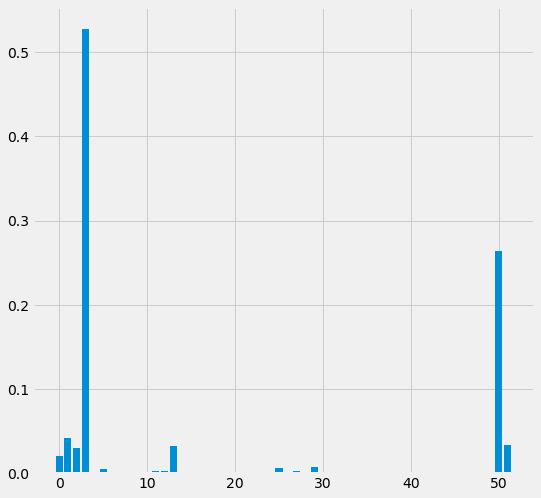

In [106]:
features = df_dados9.columns
importance = random_forest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	#print('Nome:Feature: %0d, Score: %.5f' % (i,v))
  print('Feature',i,':',features[i], ' Score:',round(v,3))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


## Somando e acumulando a importancia de cada variavel, podemos observar nesse gráfico que as primeiras 20 variáveis já atinge um valor interessante de performance.

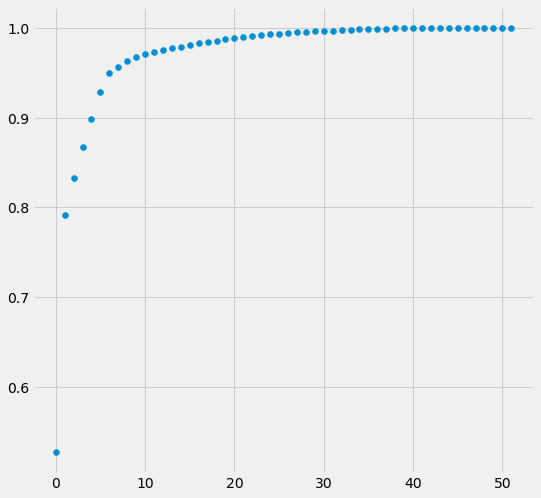

In [108]:
#
importances = random_forest.feature_importances_
variables = np.array(df_dados9.columns)
indices = np.argsort(importances)[::-1]
importances = np.round(importances[indices],4)
variables = variables[indices]
sum_importances = sum_and_plot_importances(variables, importances)

In [109]:
# Novo dataset com apenas com as principais features
df_dados10= df_dados9[['med_pond', 'TP_ESCOLA', 'TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_TEMPO_ADICIONAL']]

In [110]:
df_dados10

,med_pond,TP_ESCOLA,TP_ESTADO_CIVIL,TP_ST_CONCLUSAO,TP_ENSINO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_TEMPO_ADICIONAL
0,670.04,1,1,1,1.0,0,0,0,0,0,0,0,0,0
2,513.29,1,1,1,1.0,0,0,0,0,0,0,0,0,0
3,586.53,1,1,1,1.0,0,0,0,0,0,0,0,0,0
4,546.02,1,1,1,1.0,0,0,0,0,0,0,0,0,0
7,658.58,1,1,1,1.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534620,523.83,2,1,2,1.0,0,0,0,0,0,0,0,0,0
534621,474.87,1,1,1,1.0,0,0,0,0,0,0,0,0,0
534622,682.68,1,1,1,1.0,0,0,0,0,0,0,0,0,0
534624,565.69,1,1,1,1.0,0,0,0,0,0,0,0,0,0


In [111]:
features = df_dados10.drop(columns='med_pond')
targets = df_dados10['med_pond']

In [112]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(236916, 13)
(101536, 13)
(236916,)
(101536,)


In [113]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(X)

X = scaler.transform(X)
X_test = scaler.transform(X_test)

#
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [114]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Performance do Linear Regression nos dados de teste: MAE = %0.4f' % lr_mae)

Performance do Linear Regression nos dados de teste: MAE = 70.0365


In [115]:
random_forest = RandomForestRegressor(n_estimators = 500, random_state=60)

random_forest_mae = fit_and_evaluate(random_forest)

print('Performance do Random Forest Regression nos dados de teste: MAE = %0.4f' % random_forest_mae)

Performance do Random Forest Regression nos dados de teste: MAE = 68.9254


In [116]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Performance doo Gradient Boosted Regression nos dados de teste: MAE = %0.4f' % gradient_boosted_mae)

Performance doo Gradient Boosted Regression nos dados de teste: MAE = 68.9168


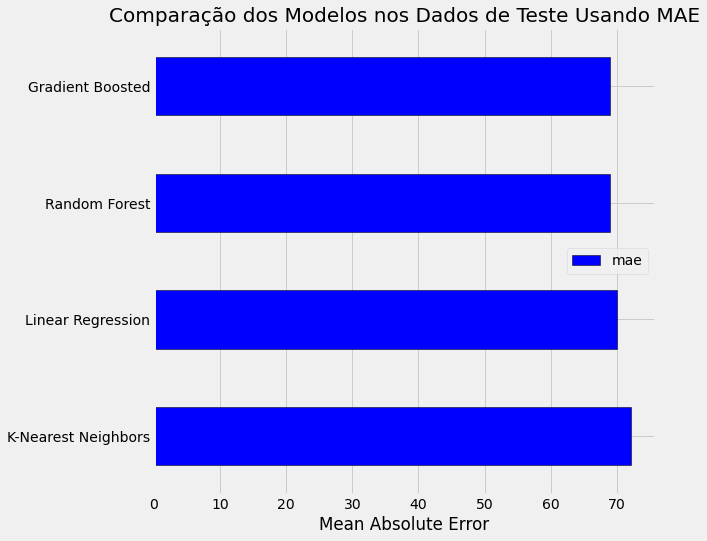

In [117]:
plt.style.use('fivethirtyeight')
figsize(8, 8)


# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae,random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'blue', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Comparação dos Modelos nos Dados de Teste Usando MAE', size = 20);

In [ ]:
loss = ['ls', 'lad', 'huber']

n_estimators = [100, 500, 900, 1100, 1500]

max_depth = [2, 3, 5, 10, 15]

min_samples_leaf = [1, 2, 4, 6, 8]

min_samples_split = [2, 4, 6, 10]

max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [ ]:
#random_cv.fit(X, y)

In [ ]:
#random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)
#random_results.head(10)

In [ ]:
#random_cv.best_estimator_

In [ ]:
#trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

#model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
#                                  min_samples_leaf = 6,
#                                  min_samples_split = 6,
#                                  max_features = None,
#                                  random_state = 42)

#grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
#                           scoring = 'neg_mean_absolute_error', verbose = 1,
#                           n_jobs = -1, return_train_score = True)

In [ ]:
#grid_search.fit(X, y)

In [ ]:
#results = pd.DataFrame(grid_search.cv_results_)

#figsize(8, 8)
#plt.style.use('fivethirtyeight')
#plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Erro em Teste')
#plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Erro em Treino')
#plt.xlabel('Número de Árvores'); plt.ylabel('Mean Abosolute Error'); plt.legend();
#plt.title('Performance vs Número de Árvores');

In [ ]:
#results.sort_values('mean_test_score', ascending = False).head(5)

In [ ]:
#default_model = GradientBoostingRegressor(random_state = 42)

#final_model = grid_search.best_estimator_

#final_model

## Shapey Value Feature Importance

In [118]:
# load JS visualization code to notebook
shap.initjs()

In [119]:
explainer = shap.TreeExplainer(gradient_boosted)
shap_values = explainer.shap_values(X)

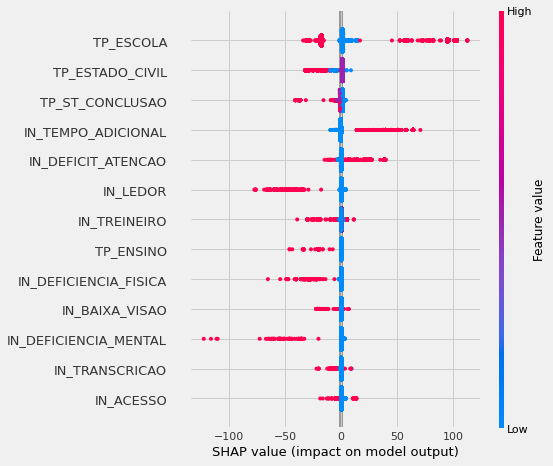

In [122]:
shap.summary_plot(shap_values, features=X, feature_names=features.columns)